$ mkdir -p ~/aiffel/camera_sticker/models

$ mkdir -p ~/aiffel/camera_sticker/images
 
$ wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/king.png

$ wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/hero.png

$ mv king.png hero.png ~/aiffel/camera_sticker/images

$ pip install opencv-python

$ pip install cmake

$ pip install dlib


In [53]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 사진 불러오기

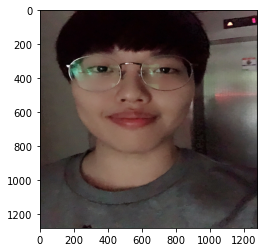

In [54]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.JPG' # 사진 경로 선언
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (1280, 1280))    # 1280*1280의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB로 변환

plt.imshow(img_rgb)
plt.show()

## 얼굴 영역 검출

In [55]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

rectangles[[(206, 206) (872, 872)]]


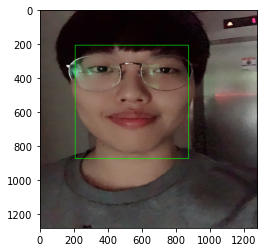

In [56]:


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 얼굴 랜드마크 검출

$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

$ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models

$ cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

In [57]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [58]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


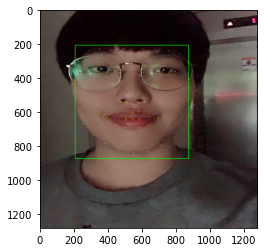

In [59]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 고양이 수염 스티커 붙이기

In [60]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(544, 495)
(x,y) : (544,495)
(w,h) : (667,667)


In [61]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat2.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h-550)) # 스티커 사이즈 = (사각형 가로길이, 사각형 세로길이 - 550)
print (img_sticker.shape)

(117, 667, 3)


In [62]:
# top-left기준이기 때문에 x,y좌표를 조정해준다(사진의 중앙이 코에 오도록)

refined_x = x - w//2 
refined_y = y - (h - 550) // 2 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (211,437)


In [63]:
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관

In [64]:
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)



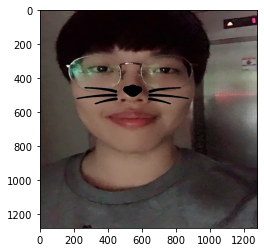

In [65]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## Discussion

1. 얼굴이 기울어진다면?

기울어진 각도를 파악하여 스티커를 회전하면 될 것 같다.어떻게 각도를 알까? 양쪽 눈 끝점을 기준으로 간격과 높이 차이를 통해 구할 수 있을 것 같다. 그 각도만큼 스티커를 회전하면 어느정도 맞지 않을까?

2. 이미지 밝기가 어둡다면?

픽셀의 대략적인 gradient로 얼굴 영역을 검출하고 랜드마크를 파악하기 때문에 밝기는 크게 영향을 미치지 않을 것 같다. 너무 어둡지만 않다면?

3. 거리가 너무 멀어진다면?

단일 픽셀로 보는게 아니기 때문에 거리가 너무 멀어진다면 제대로 검출 되지 않을 것 같다. 